This notebook generates $\hat{q}_y$ plots in the Appendix using the saved results obtained by running `run_get_results.sh`

In [8]:
import sys; sys.path.append("../") # For relative imports

import glob
import os
import pickle

from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

from utils.conformal_utils import *
from utils.experiment_utils import get_inputs_folder, get_outputs_folder, get_figs_folder


%load_ext autoreload
%autoreload 2

plt.rcParams.update({
    'font.size': 16,        # base font size
    'axes.titlesize': 18,   # subplot titles
    'axes.labelsize': 16,   # x/y labels
    # 'legend.fontsize': 16,  # legend text
    'legend.fontsize': 12,  # legend text
    'xtick.labelsize': 16,  # tick labels
    'ytick.labelsize': 16,

})
# use tex with matplotlib
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

dataset_names = {
    "plantnet": "Pl@ntNet-300K",
    "plantnet-trunc": "Pl@ntNet-300K (truncated)",
    "inaturalist": "iNaturalist",
    "inaturalist-trunc": "iNaturalist (truncated)",
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# Load in paths from folders.json
inputs_folder = get_inputs_folder()
results_folder = get_outputs_folder()
fig_folder = get_figs_folder()

In [10]:
dataset = 'plantnet'
alpha = 0.1
score = 'softmax'

os.makedirs(f'{fig_folder}/{dataset}', exist_ok=True)

In [14]:
def plot_qhats(method_qhats, method_label, dataset, alpha, folder, 
               color='tab:purple', score='softmax', ax=None, show_legend=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(3.9, 2.3))

    # Also load in standard and classwise
    with open(f'{folder}/{dataset}_{score}_alpha={alpha}_standard.pkl', 'rb') as f:
        std_metrics = pickle.load(f)
    std_qhat = std_metrics['qhat']
    
    with open(f'{folder}/{dataset}_{score}_alpha={alpha}_classwise.pkl', 'rb') as f:
        cw_metrics = pickle.load(f)
    cw_qhats = cw_metrics['qhats']

    # Sort qhats by classwise qhats
    idx = np.argsort(cw_qhats)

    # Replace infinite qhats with 1
    cw_qhats[np.isinf(cw_qhats)] = 1
    method_qhats[np.isinf(method_qhats)] = 1
    
    ax.plot(method_qhats[idx], 'o', label=method_label, alpha=0.3, markersize=4, color=color)
    ax.plot(cw_qhats[idx], '--', 
            # label='Classwise', 
            color='red')
    ax.axhline(std_qhat, 
               # label='Standard', 
               color='blue')

    # ax.set_xlabel('Class (sorted by $\\widehat{q}_y^{\\mathrm{CW}})$')
    ax.set_ylabel('$\\widehat{q}_y$')
    ax.set_xlim(-3, len(cw_qhats)+3)
    ax.spines[['right', 'top']].set_visible(False)

    if show_legend:
        ax.legend(loc='lower right')

def get_and_plot_qhats(method_name, method_label, dataset, alpha, folder, 
                       color=None, score='softmax', ax=None, show_legend=True):

    # Get qhats for method
    with open(f'{folder}/{dataset}_{score}_alpha={alpha}_{method_name}.pkl', 'rb') as f:
        metrics = pickle.load(f)
    method_qhats = metrics['qhats']

    plot_qhats(method_qhats, method_label, dataset, alpha, folder, color=color,
                       score='softmax', ax=ax, show_legend=True)

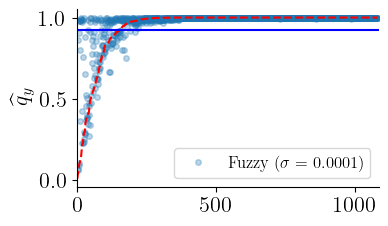

In [15]:
## A single plot
method_name = 'fuzzy-RErarity-0.0001'
method_label = 'Fuzzy ($\\sigma=0.0001$)'
get_and_plot_qhats(method_name, method_label, dataset, alpha, results_folder, score='softmax', ax=None)

Saved plot to figs/plantnet/plantnet_softmax_alpha=0.1_qhats.pdf


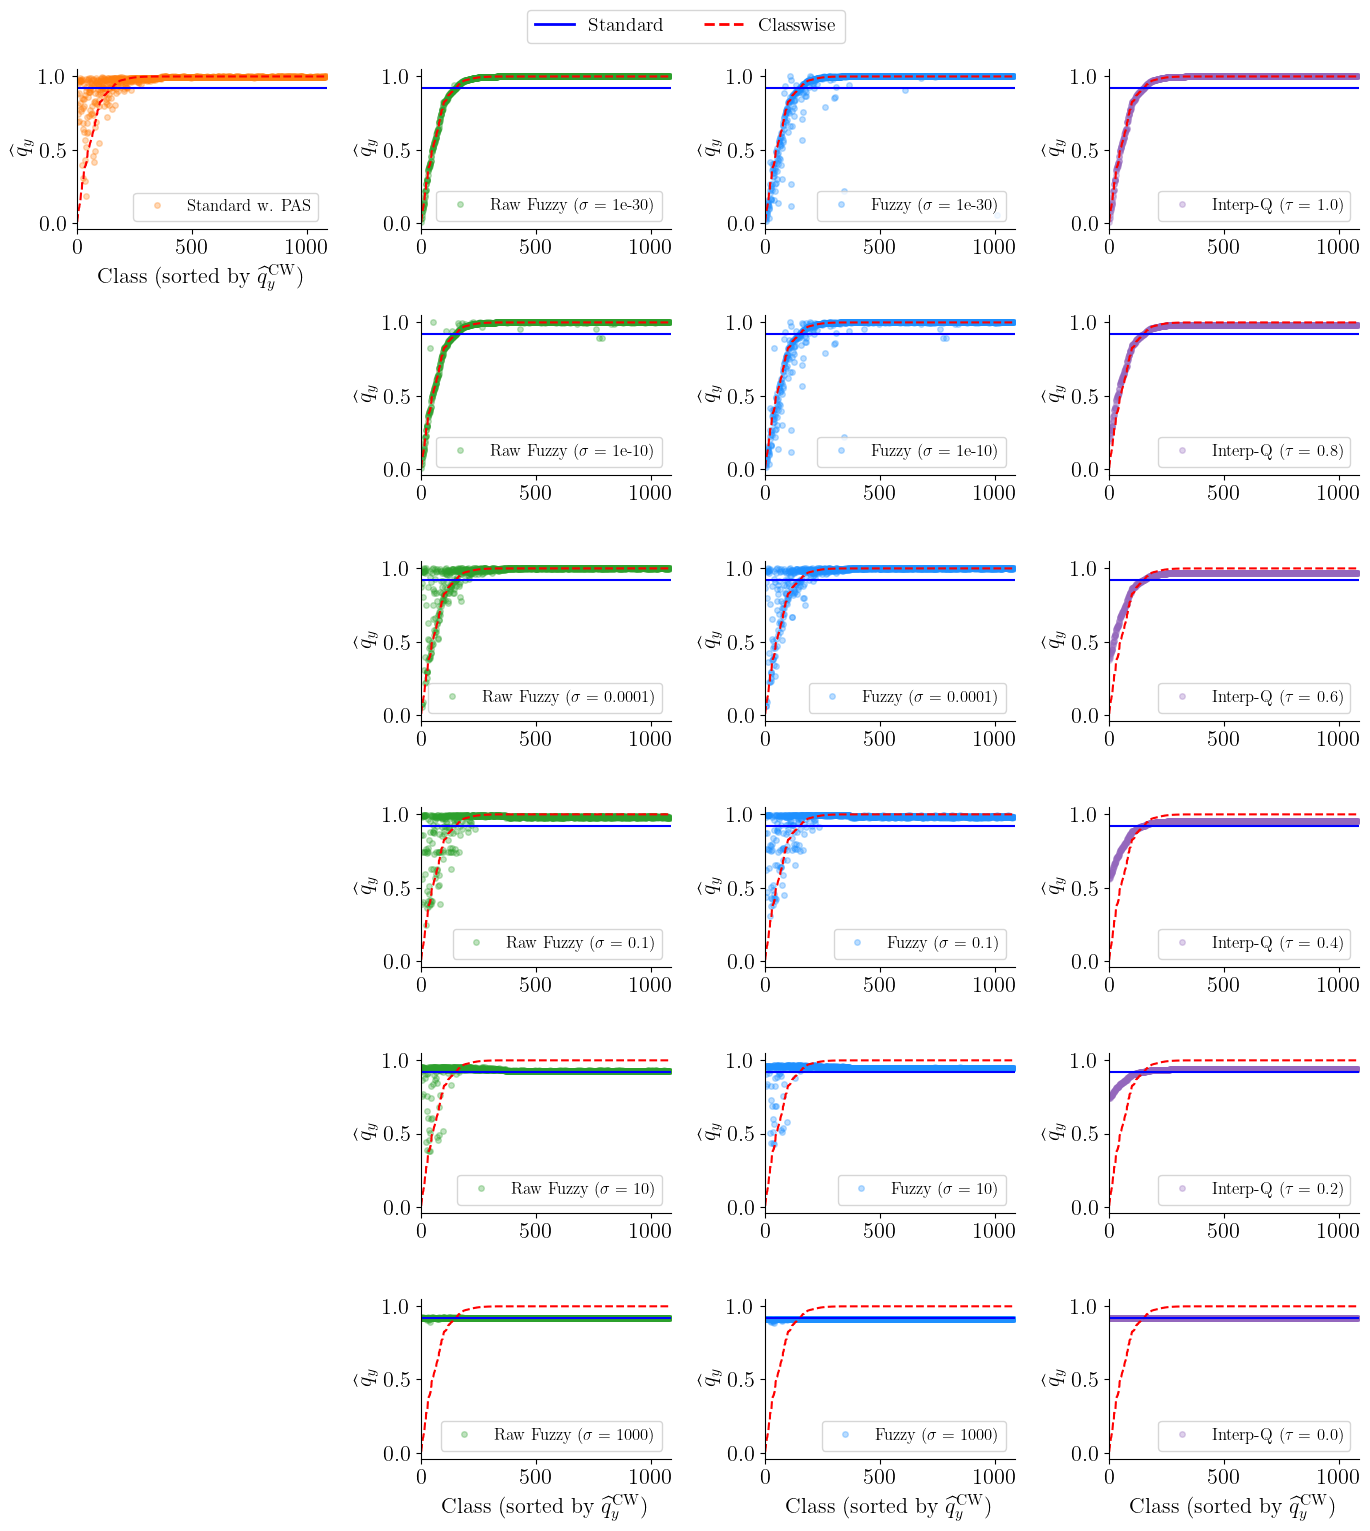

In [18]:
## Plot everything together

fuzzy_bandwidths = [1e-30, 1e-10, 0.0001, .1 , 10, 1000]
cvx_weights = [0., 1-0.8, .4, .6, .8, 1.]

nrows = 6
fig, axes = plt.subplots(nrows, 4, figsize=(14,2.5*len(cvx_weights)))

## --- Column 1: PAS ---
train_labels_path = f'{inputs_folder}/{dataset}_train_labels.npy'
train_labels = np.load(train_labels_path)
num_classes = np.max(train_labels) + 1
train_class_distr = np.array([np.sum(train_labels == k) for k in range(num_classes)]) / len(train_labels) 

method_name = 'prevalence-adjusted'
with open(f'{results_folder}/{dataset}_{score}_alpha={alpha}_{method_name}.pkl', 'rb') as f:
    metrics = pickle.load(f)
PAS_qhat = metrics['qhat']

effective_PAS_qhats = 1 + PAS_qhat * train_class_distr - train_class_distr
method_qhats = effective_PAS_qhats
plot_qhats(method_qhats, 'Standard w. PAS', dataset, alpha, results_folder, color='tab:orange',
           score='softmax', ax=axes[0][0], show_legend=True)

# Remove other axes in column 1
for i in range(1, nrows):
    axes[i, 0].axis("off")

##--- Column 1: Raw Fuzzy ---
fuzzy_bandwidths = [1e-30, 1e-10, 0.0001, .1 , 10, 1000]
for i, bw in enumerate(fuzzy_bandwidths):
    get_and_plot_qhats(f'fuzzy-rarity-{bw}', f'Raw Fuzzy ($\\sigma=$ {bw})',
                       dataset, alpha, results_folder, color='tab:green',
                       score='softmax', ax=axes[i][1], show_legend=True)

##--- Column 3: (reconformalized) Fuzzy ---
fuzzy_bandwidths = [1e-30, 1e-10, 0.0001, .1 , 10, 1000]
for i, bw in enumerate(fuzzy_bandwidths):
    get_and_plot_qhats(f'fuzzy-RErarity-{bw}', f'Fuzzy ($\\sigma=$ {bw})', 
                       dataset, alpha, results_folder, color='dodgerblue',
                       score='softmax', ax=axes[i][2], show_legend=True)

##--- Column 3: Interp-Q ---
cvx_weights = [0., 1-0.8, .4, .6, .8, 1.][::-1]
for i, w in enumerate(cvx_weights):
    get_and_plot_qhats(f'cvx-cw_weight={w}', f'Interp-Q ($\\tau=$ {w:.1f})', 
                       dataset, alpha, results_folder, color='tab:purple',
                       score='softmax', ax=axes[i][3], show_legend=True)

# # Add column titles
# axes[0,0].set_title('Standard w. PAS')
# axes[0,1].set_title('Raw Fuzzy')
# axes[0,2].set_title('Fuzzy')
# axes[0,3].set_title('Interp-Q')

# Add y-axis labels
xlabel = 'Class (sorted by $\\widehat{q}_y^{\\mathrm{CW}})$'
axes[0,0].set_xlabel(xlabel)
for i in [1,2,3]:
    axes[-1,i].set_xlabel(xlabel)


# Global legend for Standard and Classwise
# Define custom legend handles
handles = [
    Line2D([0], [0], color='blue', linestyle='-', linewidth=2, label='Standard'),
    Line2D([0], [0], color='red',  linestyle='--', linewidth=2, label='Classwise'),
]

# Add a global legend at the bottom of the figure
fig.legend(
    fontsize=14,
    handles=handles,
    loc='upper center',
    ncol=2,
    bbox_to_anchor=(0.5, 1.03)
)


plt.tight_layout()


# Save
save_path = f'{fig_folder}/{dataset}/{dataset}_{score}_alpha={alpha}_qhats.pdf'
plt.savefig(save_path, bbox_inches='tight')
print('Saved plot to', save_path)
